# OSM - Charging Station Statistics

## 0 Imports and Paths

The following packages will be needed for this notebook. Make sure you have them installed in your environment!

In [25]:
# Imports:
import geopandas as gpd
import pandas as pd
import os
import mplleaflet
from matplotlib import pyplot as plt

Paths for in- and output files:

In [2]:
# INPUT OPTIONS
CS_SOURCE_DIR = os.path.abspath("./data/out")
CS_DATA_FILENAME = "osm_cs.geojson"
DISTRICTS_SOURCE_DIR = os.path.abspath("./data")
DISTRICTS_SHP_FILENAME = "muenchen.shp"

# OUTPUT OPTIONS
OUT_DIR = os.path.abspath("./data/out")
MAP_OUT_FILENAME = "cs_map.html"
OPERATOR_HIST = 'operator_hist.html'

## 1 Introduction

In this notebook, we take a look at the charging station data retrieved from open street maps in the last exercise. Therefore, we analyze specific features of the charging stations (CS) like locations and operators. We want to extract the following information:
    
    1. Number of CS per district (per "Bezirksteil")
    2. Density of CS: Number of CS per squarekm (for each district)
    3. Number of CS per operator

In order to answer these questions, we perform the following steps:

    1. Loading districts of Munich and sorting out the irrelevant elements (Section 2)
    2. Loading charging station data (Section 2)
    3. Exploring the CS data set regarding specific tags (voltage, amperage, operator and number of outlets; Section 3)
    4. Cleaning the operator tags (Section 3)
    5. Calculate and visualize the statistics (Section 3 and 4)

## 2 Load Input Data

First of all, import the two data sources into geopandas dataframes:

    1. dataframe "munich_districts": The districts of Munich are given as polygons in a shapefile.
    2. dataframe "munich_cs": The CS data is given as a GeoJSON file.
    
Info: In order to import the data, use the function "read_file" from geopandas!

In [139]:
# Load shapefile
munich_districts = gpd.read_file(os.path.join(DISTRICTS_SOURCE_DIR,DISTRICTS_SHP_FILENAME))

# Load charging station data
munich_cs = gpd.read_file(os.path.join(CS_SOURCE_DIR,CS_DATA_FILENAME), driver='GeoJSON')

Look at the data in munich_districts: It contains not only districts, which are of type "Bezirksteil". It also includes the less detailed "Stadtbezirke" as well as the "Stadt München". For the subsequent analysis you only need "Bezirksteile".

In [47]:
munich_districts

,osm_id,name,administra,admin_leve,member_of,geometry
0,66803,Bezirksteil Altaubing,22.1,10,54382.0,"POLYGON ((11.36774 48.16811, 11.36778 48.16819..."
1,66108,Bezirksteil Altbogenhausen,13.7,10,56392.0,"POLYGON ((11.59522 48.14166, 11.59693 48.14579..."
2,66104,Bezirksteil Alte Heide-Hirschau,12.3,10,56390.0,"POLYGON ((11.58420 48.19040, 11.58443 48.19040..."
3,66784,Bezirksteil Alte Kaserne,09.5,10,54387.0,"POLYGON ((11.53978 48.15540, 11.54255 48.15685..."
4,2624998,Bezirksteil Alt Moosach,10.1,10,54385.0,"POLYGON ((11.50197 48.19237, 11.50514 48.19620..."
...,...,...,...,...,...,...
129,54375,Stadtbezirk Sendling-Westpark,07,9,62428.0,"POLYGON ((11.50167 48.10273, 11.50214 48.10465..."
130,54373,Stadtbezirk Thalkirchen-Obersendling-Forstenri...,19,9,62428.0,"POLYGON ((11.47094 48.08300, 11.47097 48.08316..."
131,52747,Stadtbezirk Trudering-Riem,15,9,62428.0,"POLYGON ((11.63990 48.11694, 11.64190 48.12053..."
132,56395,Stadtbezirk Untergiesing-Harlaching,18,9,62428.0,"POLYGON ((11.54170 48.07604, 11.54195 48.07690..."


Therfore, filter the munich_districts to extract all areas, which are of type "Bezirksteil".

Hint: There is a more comfortable way than filtering the dataframe by "name".

In [92]:
# Filter "munich_districts" to extract all areas of type "Bezirksteil", overwrite the variable "munich_districts":
bezirksteil_in_munich_districts = ["Bezirksteil" in munich_districts.at[i, "name"] for i in range(len(munich_districts))]
munich_districts = munich_districts.loc[bezirksteil_in_munich_districts]


In [93]:
munich_districts

,osm_id,name,administra,admin_leve,member_of,geometry
0,66803,Bezirksteil Altaubing,22.1,10,54382.0,"POLYGON ((11.36774 48.16811, 11.36778 48.16819..."
1,66108,Bezirksteil Altbogenhausen,13.7,10,56392.0,"POLYGON ((11.59522 48.14166, 11.59693 48.14579..."
2,66104,Bezirksteil Alte Heide-Hirschau,12.3,10,56390.0,"POLYGON ((11.58420 48.19040, 11.58443 48.19040..."
3,66784,Bezirksteil Alte Kaserne,09.5,10,54387.0,"POLYGON ((11.53978 48.15540, 11.54255 48.15685..."
4,2624998,Bezirksteil Alt Moosach,10.1,10,54385.0,"POLYGON ((11.50197 48.19237, 11.50514 48.19620..."
...,...,...,...,...,...,...
103,66802,Bezirksteil Untermenzing-Allach,23.2,10,54383.0,"POLYGON ((11.43047 48.18875, 11.43089 48.19342..."
104,66980,Bezirksteil Untersendling,06.1,10,54393.0,"POLYGON ((11.53504 48.13033, 11.53884 48.12893..."
105,66963,Bezirksteil Waldperlach,16.5,10,56397.0,"POLYGON ((11.65426 48.08050, 11.65496 48.08598..."
106,52208,Bezirksteil Waldtrudering,15.4,10,52747.0,"POLYGON ((11.66050 48.10245, 11.66118 48.10388..."


In [140]:
munich_cs

,operator,capacity,amperage,voltage,id,geometry
0,Stadt München,None,None,None,4.013012e+08,POINT (11.57398 48.15893)
1,None,None,32,400,1.271358e+09,POINT (11.68969 48.13300)
2,E.On,None,None,None,1.330522e+09,POINT (11.54603 48.13266)
3,Stadtwerke München,2,None,None,1.475946e+09,POINT (11.53757 48.15324)
4,None,None,None,None,1.895124e+09,POINT (11.52806 48.13335)
...,...,...,...,...,...,...
446,Stadtwerke München,2,None,None,6.897900e+09,POINT (11.57020 48.10193)
447,Stadtwerke München,2,None,None,6.902974e+09,POINT (11.59413 48.11640)
448,Stadtwerke München,2,None,None,6.902974e+09,POINT (11.59414 48.11649)
449,Stadtwerke München,2,None,None,6.943224e+09,POINT (11.57482 48.11833)


**Checkpoint:**

At this point you should have the two dataframes for munich_districts (containing all 108 Bezirksteile) and the CS data (containing ~400-500 charging stations).

## 3 Generating Charging Station Statistics

When working with unfamiliar data you should first take a look at some "high level" figures, before digging in too deep. This first step is called "explorative data analysis": You manually examine some properties and try to get a feel for the included information and data quality of the data set. Aggregating functions (sum, average, min, max, unique values, percentages of specific features) are quite helpful in order to paint this big picture.

After having seen, what information you may use in the dataset, you think about relevant questions, you would like to answer. As mentioned in the Introduction, in this exercise we would like to analyze the following aspects of the charging infrastructure in Munich:

    1. Number of CS per district (per "Bezirksteil")
    2. Density of CS: Number of CS per squarekm (for each district)
    3. Number of CS per operator


### 3.1 Explorative Data Analysis and Pre-Processing

How many CS do we have in our dataframe munich_cs? Save the number in the variable n_cs and print the value!

In [96]:
# Count the number of charging stations in "munich_cs" and store the result in variable "n_cs":
n_cs = len(munich_cs)


print(n_cs)

451


**Voltages and Amperages:**
* What are the unique voltage values in the data set? Save the list in the variable unique_voltage_values and print the values.
* What are the unique amperages values in the data set? Save the list in the variable unique_amperage_values and print the values.

In [97]:
print(munich_cs)

               operator capacity amperage voltage            id  \
0         Stadt München     None     None    None  4.013012e+08   
1                  None     None       32     400  1.271358e+09   
2                  E.On     None     None    None  1.330522e+09   
3    Stadtwerke München        2     None    None  1.475946e+09   
4                  None     None     None    None  1.895124e+09   
..                  ...      ...      ...     ...           ...   
446  Stadtwerke München        2     None    None  6.897900e+09   
447  Stadtwerke München        2     None    None  6.902974e+09   
448  Stadtwerke München        2     None    None  6.902974e+09   
449  Stadtwerke München        2     None    None  6.943224e+09   
450  Stadtwerke München        2     None    None  6.943224e+09   

                      geometry  
0    POINT (11.57398 48.15893)  
1    POINT (11.68969 48.13300)  
2    POINT (11.54603 48.13266)  
3    POINT (11.53757 48.15324)  
4    POINT (11.52806 48.13335)

In [111]:
# Save the unique voltages and amperages in the following two variables:
unique_voltage_values = munich_cs['voltage'].unique()
unique_amperage_values = munich_cs['amperage'].unique()


print(unique_voltage_values)
print(unique_amperage_values)

[None '400' '230;400' '230']
[None '32' '16' '125' '6' '300' '143']


**Data quality:**
* How many fields of voltage, amperage, operator and outlets are empty (na)?\
    Save the number of each field in a variable called n_voltage_na, n_amperage_na, n_operator_na and n_outlets_na!
* Print the percentage of na-values for each field.

Which properties hava a big share of na-values? Which properties promise more significant results for the analysis?

In [135]:
test = munich_cs['voltage'].isna().sum()
print(test)

389


In [141]:
# Count the amount of empty fiels for voltage, amperage, operator and outlets in the following four variables:
n_voltage_na = munich_cs['voltage'].isna().sum()
n_amperage_na = munich_cs['amperage'].isna().sum()
n_operator_na = munich_cs['operator'].isna().sum()
n_outlets_na = munich_cs['capacity'].isna().sum()


# Now, let's print the share of na-values for each attribute in relation to the total of charging stations:
print(n_voltage_na/n_cs)
print(n_amperage_na/n_cs)
print(n_operator_na/n_cs)
print(n_outlets_na/n_cs)

0.8625277161862528
0.8536585365853658
0.04656319290465632
0.10643015521064302


Since voltages and amperages are only present in some of the rows, analysis would only consider few data and lead to incorrect conclusions. Fortunately, two of the four properties are better than the others and therefore, we now take a look at operators and the number of outlets per CS.

First, print all different values for operators and outlets and the count for each value.

* What are the "big players" for CS in Munich?
* What is the usual number of outlets per CS?

In [160]:
# Print the number of charging stations for each operator:
print(munich_cs.groupby('operator')['operator'].count().sort_values(ascending=False))

# Print the number of charging stations, that provide the same number of outlets:
print(munich_cs.groupby('capacity')['capacity'].count().sort_values(ascending=False))

operator
Stadtwerke München             345
SWM                             26
Bauhaus                          5
Stadtwerke München GmbH          5
BMW                              4
SIEMENS AG                       3
Bayernwerk                       3
Sparda Bank                      3
Sony Music                       3
SWM Stadtwerke München           3
BMWi/ChargeNow                   2
ALDI Einkauf GmbH & Co. oHG      2
Statdwerke München               2
E-On                             1
Aldi Süd                         1
Aldi (Süd)                       1
ARRI AG                          1
ALDI Süd                         1
Bw Fuhrpark GmbH                 1
ChargeNow                        1
Deutsche Telekom                 1
Deutsches Museum                 1
allegro                          1
E.On                             1
EON                              1
Elements                         1
LIDL                             1
VW                               1
Mc Donalds 

### 3.2 Generating Statistics

In this subsection we will answer the above-mentioned questions regarding CS in Munich.

#### 3.2.1 Charging Stations per District

##### 3.2.1.1 Number of CS per district

Let's start with the number of CS per district (per "Bezirksteil"): Count for each munich_district, how many CS are located in this district and save this number as a new column named "n_cs" in the dataframe munich_district.

**Hint:**\
You may iterate over all elements of munich_district with a loop. But there is a much more elegant way of calculating this number in just one line: Use a lambda function in order to achieve the result.

In [12]:
# Count the number of CS per district and store the result in a new column in "munich_districts", which is named "n_cs":
# munich_districts["n_cs"] = ...


##### 3.2.1.2 Density of CS: Number of CS per squarekm

Since we know, that districts can be quite different (different areas, different population figures, and so on), the pure number of CS is not very informative. That's why, we introduce the area of a district as a reference quantity in order to calculate the number of CS per squarekm for each district. Therefore, we first need to calculate the area of all districts.

**Hints:**
* To calculate the area of a geometry use a shapely function!
* As you may remember from the shapely basics notebook, shapely is unaware of measurement units. That's why, shapely can only use the axes of the coordinate systems you are using for a geometry. As long as you use metric coordinates in an euclidean plane (e.g. a square with (0,0),(1,0),(1,1),(0,1)), shapely is able to calculate the area of polygons. Since latitude and longitude from WGS84 (GPS coordinates) are neither metric (degrees, minutes, seconds) nor euclidean (spherical coordinates), we first have to transform our districts into a metric coordinate system. For Munich, we use Gauss-Krüger Zone 4 (EPSG:31468), which references points as x- and y-coordinates in **meters**.\
    Interested readers may refer to:
  * [https://wiki.tum.de/display/smartemobilitaet/GIS%3A+Kartografie+und+Projektionen]
  * [https://wiki.tum.de/display/smartemobilitaet/Coordinate+Systems%2C+Projections%2C+Grids+and+Visualization+in+Python%3A+Practical+Guide]

In order to calculate the areas of each district you have to implement the following steps:

    1. Transform the munich_districts into the metric system Gauss Krüger Zone 4.
    2. Calculate the area of each district in squarekm and save the result into a new column named "area_sqkm".
    3. Transform the munich_districts back to WGS84.

In [13]:
# TRANSFORMATION SETTINGS
WGS84_EPSG = {'init': 'epsg:4326'}
METRIC_EPSG = {'init': 'epsg:31468'} # Gauss-Kruger Zone 4

munich_districts = munich_districts.to_crs(METRIC_EPSG)
munich_districts["area_sqkm"] = munich_districts.area/1000000
munich_districts = munich_districts.to_crs(WGS84_EPSG)

Now calculate the number of CS per squarekm for each district and save the result in a new column named "n_cs_per_sqkm".

In [14]:
munich_districts["n_cs_per_sqkm"] = munich_districts.n_cs/munich_districts.area_sqkm

##### 3.2.1.3 Visualization

Subsequently, we visualize the calculated results of the CS density per district in a map:

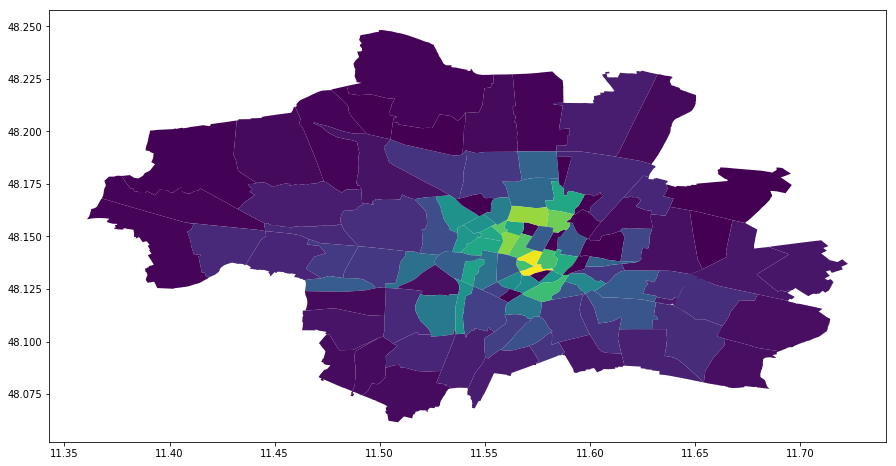

In [15]:
# How can we set the opacity ?
fig, ax = plt.subplots()
fig.set_size_inches(15,15)
munich_districts.plot(ax = ax, column="n_cs_per_sqkm")

#### 3.2.2 Charging Station Operators

During the explorative data analysis you printed all operators and the number of CS operated by that company. As you may have noticed, there were different names for the same operator (e.g. "Stadtwerke München", "SWM", "Stadtwerke München GmbH", etc.). In order to get clean results from your analysis, you have to merge the different operator names.

Generate a unique list of operators and store it into the variable "unique_operators"!\
Also save the number of unique operators in the variable "N_unique_operators_raw"!

In [16]:
# Generate a unique list of operators and store it in the variable "unique_operators":
# unique_operators = ...


# Save the number of unique operators in the variable "N_unique_operators_raw":
# N_unique_operators_raw = ...


Now, define a mapping dictionary of operator names, in which you assign operators from the dataframe to unique company names.

In [17]:
# Define operator mapping
operator_map = {
    'Stadt München' : 'Stadt München',
    'Sixt' : 'Sixt',
    None : 'Unknown',
    'E.On' : 'E.ON',
    'EON' : 'E.ON',
    'E-On' : 'E.ON',
    'Stadtwerke München' : 'SWM',
    'SWM' : 'SWM',
    'SWM Stadtwerke München' : 'SWM',
    'Stadtwerke München GmbH' : 'SWM',
    'SWM Stadtwerke München GmbH' : 'SWM',
    'Statdwerke München' : 'SWM',
    'BMWi/ChargeNow' : 'ChargeNow',
    'ChargeNow' : 'ChargeNow',
    'BMW' : 'ChargeNow',
    'Landratsamt München' : 'Landratsamt München',
    'Elements' : 'Elements',
    'PASING ARCADEN' : 'PASING ARCADEN',
    'SIEMENS AG' : 'SIEMENS AG',
    'ALDI Süd' : 'ALDI Süd',
    'Aldi (Süd)' : 'ALDI Süd',
    'ALDI Einkauf GmbH & Co. oHG' : 'ALDI Süd',
    'Aldi Süd' : 'ALDI Süd',
    'Rewe' : 'Rewe',
    'Sony Music' : 'Sony Music',
    'Sunyard' : 'Sunyard',
    'Deutsches Museum' : 'Deutsches Museum',
    'Sparda Bank' : 'Sparda Bank',
    'Nissan' : 'Nissan',
    'Bw Fuhrpark GmbH' : 'Bw Fuhrpark GmbH',
    'Bauhaus' : 'Bauhaus',
    'VW' : 'VW',
    'P+R Park & Ride GmbH' : 'P+R Park & Ride GmbH',
    'Deutsche Telekom' : 'Deutsche Telekom',
    'LIDL' : 'LIDL',
    'ARRI AG' : 'ARRI AG',
    'Bayernwerk' : 'Bayernwerk',
    'allegro' : 'allegro',
    'Mc Donalds' : 'Mc Donalds'
}

As a last step, use a lambda function to apply the mapping you defined above and save the new number of unique operators in a variable called "N_unique_operators"!

In [18]:
# Apply a lambda function in order to perform the mapping and overwrite the "operator"-column in "munich_cs":
# munich_cs.operator = ...


# Save the number of unique operators after mapping in the variable "N_unique_operators":
# N_unique_operators = ...


## 4 Results

In this section, we print and plot the results of your calculations:

* Number of CS in Munich
* Number of unique operators before mapping
* Number of unique operators after mapping
* List of unique operators after mapping
* Plot number of charging stations per operator in a histogram

In [19]:
###########################################################################################################
### Print Results
###########################################################################################################

print("+++ CHARGING STATION STATISTICS +++\n\n")

print("Number of CS in Munich: {}\n".format(len(munich_cs.geometry)))

print("Number of unique operators before mapping: {}\n".format(N_unique_operators_raw))

print("Number of unique operators after mapping: {}\n".format(N_unique_operators))

print("Unique operators after mapping: {}\n".format(munich_cs.operator.unique()))

###########################################################################################################
### Visualization
###########################################################################################################

# Plot the districts of Munich in a semi-transparent way, include the count of charging stations as color
ax = munich_districts.plot(alpha=0.9, edgecolor='k', column='n_cs_per_sqkm', cmap='Greys')

# Add the charging stations to the plot
munich_cs.plot(ax=ax)

# Show results on a map
mplleaflet.show(fig=ax.figure, crs=munich_cs.crs, tiles='cartodb_positron', path=OUT_DIR+"//"+MAP_OUT_FILENAME)

# Open second figure for operator histogram
plt.figure()
plt.title("Number of Charging Stations per Operator")

# Plot operator histogram
histogram_data = munich_cs.operator.value_counts()
plt.bar(x = list(range(N_unique_operators)), tick_label = list(histogram_data.keys()), height = list(histogram_data.values))
plt.xticks(rotation='vertical')
plt.show()

+++ CHARGING STATION STATISTICS +++


Number of CS in Munich: 451

Number of unique operators before mapping: 38

Number of unique operators after mapping: 26

Unique operators after mapping: ['Stadt München' 'Unknown' 'E.ON' 'SWM' 'ChargeNow' 'Landratsamt München'
 'Elements' 'PASING ARCADEN' 'SIEMENS AG' 'ALDI Süd' 'Rewe' 'Sony Music'
 'Sunyard' 'Deutsches Museum' 'Sparda Bank' 'Nissan' 'Bw Fuhrpark GmbH'
 'Bauhaus' 'VW' 'P+R Park & Ride GmbH' 'Deutsche Telekom' 'LIDL' 'ARRI AG'
 'Bayernwerk' 'allegro' 'Mc Donalds']



KeyboardInterrupt: 